In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\asoom\AppData\Local\Temp\ipykernel_38952\2615329546.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)


[]


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 623 images belonging to 2 classes.
Train data:
  - Images: (8, 150, 150, 3)
  - Labels: (8, 2)
Validation data:
  - Images: (8, 150, 150, 3)
  - Labels: (8, 2)
Test data:
  - Images: (8, 150, 150, 3)
  - Labels: (8, 2)


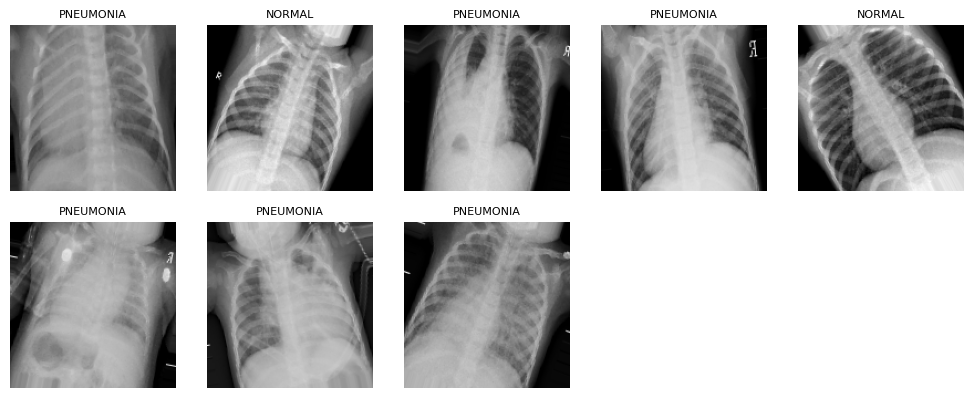

In [7]:

# Define your data directories
train_dir = 'D:/IT/Smesters/th5_SMESTER/305/PROJECT_TEST/archive/chest_xray/train'
test_dir = 'D:/IT/Smesters/th5_SMESTER/305/PROJECT_TEST/archive/chest_xray/test'
validation_dir = 'D:/IT/Smesters/th5_SMESTER/305/PROJECT_TEST/archive/chest_xray/val'

def create_data_generators(train_dir, validation_dir, test_dir, target_size=(150, 150), batch_size=8, classes=['NORMAL', 'PNEUMONIA']):
    """
    Creates ImageDataGenerators for training, validation, and testing.

    Args:
        train_dir: Directory containing training images.
        validation_dir: Directory containing validation images.
        test_dir: Directory containing test images.
        target_size: The desired size for image resizing.
        batch_size: The number of images per batch.
        classes: List of class names (modify if needed).

    Returns:
        A tuple of training, validation, and test data generators.
    """

    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       shear_range=0.2,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        target_size=target_size)

    validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  target_size=target_size)

    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      target_size=target_size)  

    return train_generator, validation_generator, test_generator

# Create data generators
train_generator, validation_generator, test_generator = create_data_generators(train_dir, validation_dir, test_dir)

train_sample = next(train_generator)
validation_sample = next(validation_generator)
test_sample = next(test_generator)
print("Train data:")
print("  - Images:", train_sample[0].shape)  # Shape of images
print("  - Labels:", train_sample[1].shape)  # Shape of labels

print("Validation data:")
print("  - Images:", validation_sample[0].shape)
print("  - Labels:", validation_sample[1].shape)

print("Test data:")
print("  - Images:", test_sample[0].shape)
print("  - Labels:", test_sample[1].shape)



import matplotlib.pyplot as plt

# Define class names (assuming train_generator.class_indices is available)
class_names = list(train_generator.class_indices.keys())

# Plot sample images with informative titles and layout adjustments
plt.figure(figsize=(10, 10))
num_images = 8  # Adjust as needed (multiple of rows & columns)
rows = 5
cols = 5

for images, labels in train_generator:
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)

        # Preprocess image for better visualization (optional)
        image = images[i]  # Consider normalization or scaling if needed

        plt.imshow(image)

        # Determine title based on label format
        if labels.ndim > 1:  # Multi-class (categorical)
            predicted_class = labels[i].argmax()
            title = f"{class_names[predicted_class]}"
        else:  # Binary labels
            title = f"{class_names[int(labels[i])]}"

        plt.title(title, fontsize=8)
        plt.axis("off")

    break  # Only plot one batch
plt.tight_layout()
plt.show()

In [9]:
# Load the MobileNet model (pre-trained or custom)
mobile_net = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)  # Load pre-trained MobileNet
for layer in mobile_net.layers:
    layer.trainable = True  # Freeze pre-trained layers (uncomment to freeze)

x = mobile_net.output  # Output of the pre-trained MobileNet
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global average pooling
predictions = tf.keras.layers.Dense(units=2, activation='sigmoid')(x)  # Output layer with 2 units for 2 classes

C:\Users\asoom\AppData\Local\Temp\ipykernel_38952\2861857421.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)  # Load pre-trained MobileNet


In [17]:
model = tf.keras.Model(inputs=mobile_net.input, outputs=predictions)
# Compile the model
# Adjust the learning rate
'''
adam_custom_lr = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_custom_lr, loss='binary_crossentropy', metrics=['accuracy']) 
'''

from tensorflow.keras.optimizers import Adam

# Adjust the learning rate
adam_custom_lr = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_custom_lr, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model (adjust epochs and other parameters as needed)
history = model.fit(train_generator, epochs=5, batch_size=8, validation_data=validation_generator)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


Epoch 1/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 214s 314ms/step - accuracy: 0.9824 - loss: 0.0652 - val_accuracy: 0.8750 - val_loss: 0.1277
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 313ms/step - accuracy: 0.9822 - loss: 0.0584 - val_accuracy: 0.9375 - val_loss: 0.1168
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 312ms/step - accuracy: 0.9810 - loss: 0.0559 - val_accuracy: 0.9375 - val_loss: 0.1170
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 312ms/step - accuracy: 0.9845 - loss: 0.0462 - val_accuracy: 0.9375 - val_loss: 0.1172
Epoch 5/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 203s 311ms/step - accuracy: 0.9855 - loss: 0.0620 - val_accuracy: 0.9375 - val_loss: 0.1193
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8777 - loss: 0.4402
Test accuracy: 0.8940609693527222


In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')

fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [7]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_generator' is your test data generator
# Iterate over the generator to get images and their labels
for image_batch, label_batch in test_generator:
    # Make predictions for the current batch of images
    predictions = model.predict(image_batch)

    # Iterate over each image in the batch
    for i in range(len(predictions)):
        # Get the prediction result and probability
        predicted_class = np.argmax(predictions[i])  # Use np.argmax to get the index of the maximum value
        probability = predictions[i][predicted_class]

        # Get the actual label
        actual_label = label_batch[i]

        # Interpret prediction result
        if predicted_class == 1:
            result = 'Pneumonia'
        else:
            result = 'NORMAL'

        # Print prediction result and actual label
        if np.array_equal(predicted_class, actual_label):
            print(f'Prediction: {result} (Correct)')
        else:
            print(f'Prediction: {result} (Incorrect)')

        print(f'Probability: {probability:.2f}')

        # Display the image
        plt.imshow(image_batch[i])
        plt.axis('off')
        plt.show()    


NameError: name 'test_generator' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


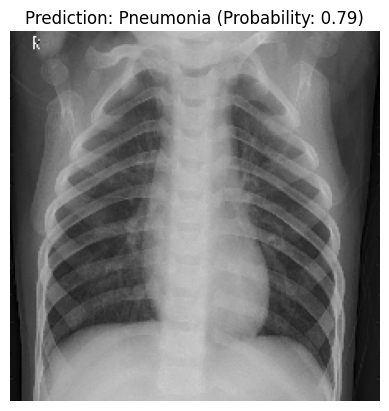

Prediction: Pneumonia


In [76]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.preprocessing import image


model = tf.keras.models.load_model('save_model_complate.h5')

def predictpneumonia(imagepath):
    # Load and preprocess the image
    img = image.loadimg(imagepath, target_size=(150, 150))  # Assuming your model expects input size (224, 224)
    x = image.img_to_array(img)
    x = tf.image.convert_image_dtype(x, tf.float32)  # Convert image to float32
    x = tf.expand_dims(x, axis=0)  # Add a batch dimension

    # Make prediction
    prediction = model.predict(x)

    # Print the entire prediction array for analysis
    print("Prediction Probabilities:", prediction)

    predicted_class = tf.argmax(prediction, axis=1).numpy()[0]  # Get predicted class
    print("Predicted Class:", predicted_class)

    # Interpret prediction result
    if predicted_class == 1:
        return 'Pneumonia'
    else:
        return 'Not Pneumonia'

if __name__ == '__main__':
    # Prompt user to input the path of the image
    image_path = 'NORMAL2-IM-0246-0001-0002.jpeg'

    # Perform prediction
    result = predict_pneumonia(image_path)
    print("Prediction:", result)

In [34]:
model.save('save_model_complate.h5')

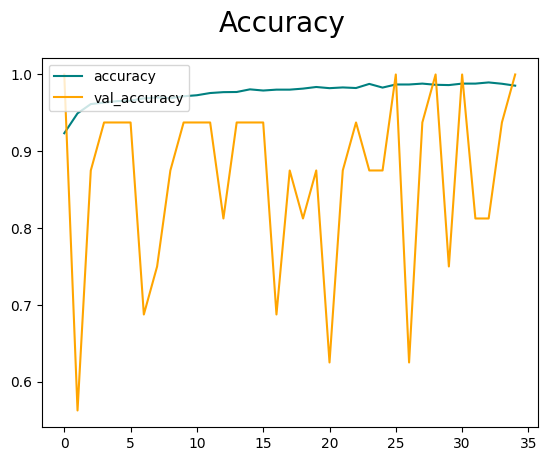

In [35]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [5]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

app = Flask(__name__)

# Load the pre-trained model
model = load_model('save_model_complate.h5')  # Replace 'save_model_complate.h5' with the actual path to your model file

@app.route('/predict', methods=['POST'])
def predict():
    # Get the image file from the request
    file = request.files['image']

    # Read the image file
    img = image.load_img(file, target_size=(150, 150))  # Assuming your model expects input size (150, 150)

    # Convert image to array
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Preprocess the image
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(img_array)

    # Interpret prediction result
    if prediction[0][0] > 0.5:
        result = 'Pneumonia'
    else:
        result = 'Normal'

    # Return the prediction result
    return jsonify({'result': result})

if __name__ == '__main__':
    app.run(debug=True)




 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

C:\Users\asoom\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
